In [1]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from imvc.datasets import LoadDataset
from imvc.decomposition import jNMF
from imvc.preprocessing import MultiViewTransformer
from imvc.ampute import Amputer
from matplotlib import colormaps
import pandas as pd
import numpy as np

In [3]:
Xs = LoadDataset.load_dataset(dataset_name="nutrimouse")
amputed_Xs = Amputer(p= 0.3, mechanism="MCAR", random_state=42).fit_transform(Xs)

In [4]:
n_components_list = [1, 2, 4, 8, 16, 24, 32]
errs = []
f_matrices = []
for n_components in n_components_list:
    pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                             jNMF(n_components = n_components, random_state=42).set_output(transform="pandas"))
    pipeline.fit(amputed_Xs)
    
    errs.append(pipeline[-1].reconstruction_err_[-1])
    f_matrices.append(pipeline[-1].H_) 

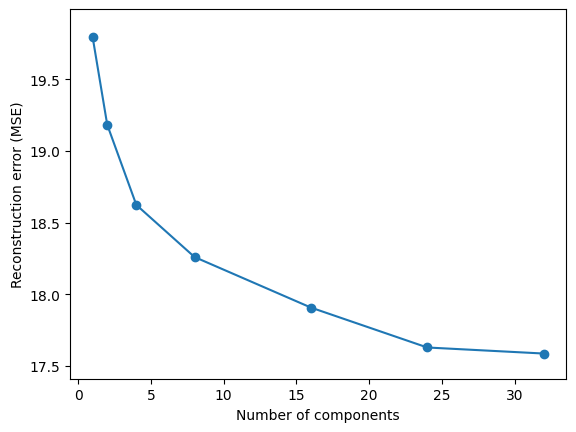

In [5]:
_ = pd.Series(errs, index= n_components_list).plot(style='-o', ylim= (min(errs)*0.99, max(errs)*1.01), ylabel= "Reconstruction error (MSE)", xlabel= "Number of components", rot= 0)

In [6]:
f_matrices = pd.concat(f_matrices[3], axis= 0)

In [7]:
selected_features = {}
for col in f_matrices:
    selected_features[f_matrices[col].idxmax()] = f_matrices[col].max()
selected_features = pd.Series(selected_features).reset_index().sort_values(by=0, ascending= False)

In [8]:
color_df = selected_features["index"].apply(lambda x: "Genes" if ((x in Xs[0].columns) and (x not in Xs[1].columns)) else ("Fatty Acids" if ((x in Xs[1].columns) and (x not in Xs[0].columns)) else "Not found")).to_frame("view")
colors = {color: colormaps["Pastel1"].colors[i] for i,color in enumerate(color_df["view"].unique())}
color_df["color"] = color_df["view"].apply(lambda x: colors[x])

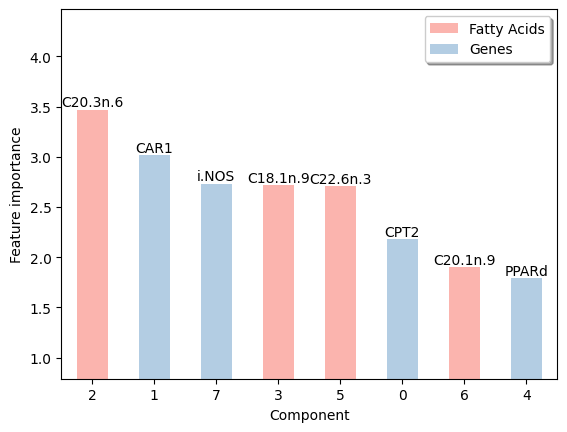

In [9]:
components_to_plot = selected_features[0]
ax = components_to_plot.plot(kind= "bar", ylim= (min(components_to_plot) -1, max(components_to_plot) +1),
                             ylabel= "Feature importance", xlabel= "Component", rot= 0, color=color_df["color"])
ax.legend(labels=color_df["view"].unique().tolist(), handles=ax.patches, fancybox=True, shadow=True)
_ = ax.bar_label(ax.containers[0], labels = selected_features["index"])